In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import numpy as np
from random import randint, seed
from torch.utils.data import Dataset
from collections import Counter

https://github.com/stevenliuyi/information-bottleneck/blob/master/information_bottleneck.ipynb <br>
function: calc_mutual_information

### Information Bottleneck theory for Deep Learning

In [2]:
n_train_samples = 50000 # number of train samples
n_test_samples = 10000 # number of test samples

groups = np.append(np.zeros(8),np.ones(8)) # 16 groups
np.random.seed(1234)
np.random.shuffle(groups)

# generate samples
seed(1234)
def generate_samples(n_samples):
    x_data = np.zeros((n_samples, 10)) # inputs
    x_int = np.zeros(n_samples) # integers representing the inputs
    y_data = np.zeros((n_samples, 2)) # outputs
    
    for i in range(n_samples):
        random_int = randint(0, 1023)
        x_data[i,:] = [int(b) for b in list("{0:b}".format(random_int).zfill(10))]
        x_int[i] = random_int
        y_data[i,0] = groups[random_int % 16]
        y_data[i,1] = 1 - y_data[i,0]
        
    return np.array(x_data, dtype=np.float32), np.array(y_data, dtype=np.float32), x_int

x_train, y_train, x_train_int = generate_samples(n_train_samples) # training dataset
x_test, y_test, _ = generate_samples(n_test_samples) # testing dataset

In [3]:
def calc_mutual_information(hidden):
    n_neurons = hidden.shape[1]
  
    # discretization 
    n_bins = 30
    bins = np.linspace(-1, 1, n_bins+1)
    indices = np.digitize(hidden, bins)
    
    # initialize pdfs
    pdf_x = Counter(); pdf_y = Counter(); pdf_t = Counter(); pdf_xt = Counter(); pdf_yt = Counter()

    for i in range(n_train_samples):
        pdf_x[x_train_int[i]] += 1/float(n_train_samples)
        pdf_y[y_train[i,0]] += 1/float(n_train_samples)      
        pdf_xt[(x_train_int[i],)+tuple(indices[i,:])] += 1/float(n_train_samples)
        pdf_yt[(y_train[i,0],)+tuple(indices[i,:])] += 1/float(n_train_samples)
        pdf_t[tuple(indices[i,:])] += 1/float(n_train_samples)
    
    # calcuate encoder mutual information I(X;T)
    mi_xt = 0
    for i in pdf_xt:
        # P(x,t), P(x) and P(t)
        p_xt = pdf_xt[i]; p_x = pdf_x[i[0]]; p_t = pdf_t[i[1:]]
        # I(X;T)
        mi_xt += p_xt * np.log(p_xt / p_x / p_t)
 
    # calculate decoder mutual information I(T;Y)
    mi_ty = 0
    for i in pdf_yt:
        # P(t,y), P(t) and P(y)
        p_yt = pdf_yt[i]; p_t = pdf_t[i[1:]]; p_y = pdf_y[i[0]]
        # I(X;T)
        mi_ty += p_yt * np.log(p_yt / p_t / p_y)
            
    return mi_xt, mi_ty

# get mutual information for all hidden layers
def get_mutual_information(hiddens):
    mi_xt_list = []; mi_ty_list = []
    for hidden in hiddens:
        mi_xt, mi_ty = calc_mutual_information(hidden)
        mi_xt_list.append(mi_xt)
        mi_ty_list.append(mi_ty)
    return mi_xt_list, mi_ty_list

In [4]:
def get_all_mutual_information():
    _activation = []
    for k in activation.keys():
        _activation.append(activation[k].detach().cpu().numpy())
    mi_xt, mi_ty = get_mutual_information(_activation)
    return mi_xt, mi_ty

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(10 , 8)
        self.fc2 = nn.Linear(8, 6)
        self.fc3 = nn.Linear(6, 4)
        self.fc4 = nn.Linear(4, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        output = F.log_softmax(x, dim=1)
        return output
model = Net().to(device)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
#         trunc_normal_(m.weight, std=.02)
        m.bias.data.fill_(0.01)
model.apply(init_weights)

activation = {}
def get_activation(name):
    def hook(model, input, output):
        if name not in activation:
            activation[name] = output.detach()
        else:
            activation[name] = torch.cat([activation[name], output.detach()])
    return hook

handle1 = model.fc1.register_forward_hook(get_activation('fc1')) 
handle2 = model.fc2.register_forward_hook(get_activation('fc2')) 
handle3 = model.fc3.register_forward_hook(get_activation('fc3'))
handle4 = model.fc4.register_forward_hook(get_activation('fc4')) 


In [6]:
optimizer = optim.SGD(model.parameters(), lr=.1)
_y_train = np.argmax(y_train, axis=1)
data, target = torch.tensor(x_train).to(device), torch.tensor(_y_train).to(device)
mi_xt_all = []; mi_ty_all = []; epochs = []
for epoch in range(0, 1000):
    activation = {}
    
    model.train()
    optimizer.zero_grad()
    output = F.log_softmax(model(data), dim=1)
    loss = F.nll_loss(output, target) # nn.CrossEntropyLoss applies internally F.log_softmax and nn.NLLLoss
    loss.backward()
    optimizer.step()
#     print(epoch, loss.item())

    if epoch % 50 == 0:
        mi_xt, mi_ty = get_all_mutual_information()
        print(mi_xt, mi_ty)
        mi_xt_all.append(mi_xt)
        mi_ty_all.append(mi_ty)
        epochs.append(epoch)
    
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            output = F.log_softmax(model(data), dim=1)
            test_loss += F.nll_loss(output, target, reduction='mean').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
        print('test_loss:', test_loss, 'correct:', correct/len(target))

[6.921128755327638, 5.368680029996653, 3.876021726431035, 2.8928263507581677] [0.6931212603355567, 0.206257500501965, 0.05758246860708007, 0.02084282634457471]
test_loss: 0.7180464267730713 correct: 0.50544
[6.921128755327638, 5.513164383687833, 2.672781151654214, 2.1438474680695] [0.6931212603355567, 0.2882212292096779, 0.07719084828003332, 0.05951539262522278]
test_loss: 0.6730822920799255 correct: 0.57178
[6.921128755327638, 5.875534197472937, 3.3071275616752174, 2.628757741026634] [0.6931212603355567, 0.4463945654935805, 0.16218045755592292, 0.1319361459092478]
test_loss: 0.6353397369384766 correct: 0.6405
[6.921128755327638, 5.892116422169893, 3.44619205601459, 2.816421691103166] [0.6931212603355567, 0.5245380246493605, 0.25088237912509376, 0.2271902365391314]
test_loss: 0.5719956755638123 correct: 0.7047
[6.921128755327638, 5.561612035364162, 3.2241722565088113, 2.878011019593856] [0.6931212603355567, 0.48695687913203645, 0.2637441774589237, 0.2453424230625112]
test_loss: 0.50854

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [8]:
mi_xt_all = np.array(mi_xt_all)
mi_ty_all = np.array(mi_ty_all)

In [9]:
cmap = plt.cm.get_cmap('cool')
def animate(i):
    title.set_text('Epoch %s' % str(epochs[i]).zfill(4))
    ax.plot(mi_xt_all[i,:], mi_ty_all[i,:], 'k-',alpha=0.2)
    if i > 0:
        for j in range(len(mi_xt_all[0])):
            ax.plot(mi_xt_all[(i-1):(i+1),j],mi_ty_all[(i-1):(i+1),j],'*-',c=cmap(j*.2),ms=10)
    return

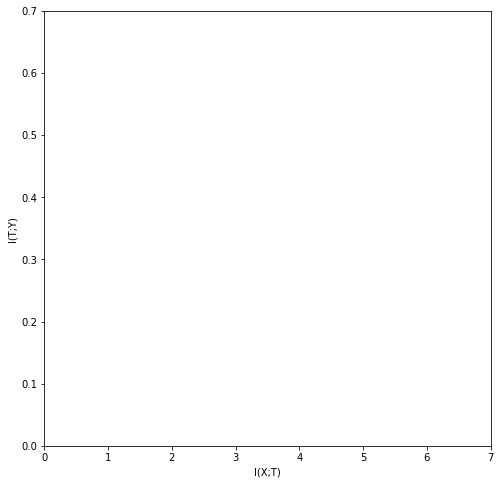

In [18]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim((0,7))
ax.set_ylim((0.,0.7))
ax.set_xlabel('I(X;T)')
ax.set_ylabel('I(T;Y)')
title = ax.set_title('')
# for i in range(1,len(mi_xt_all)):
#     animate(i)
# animate(9)

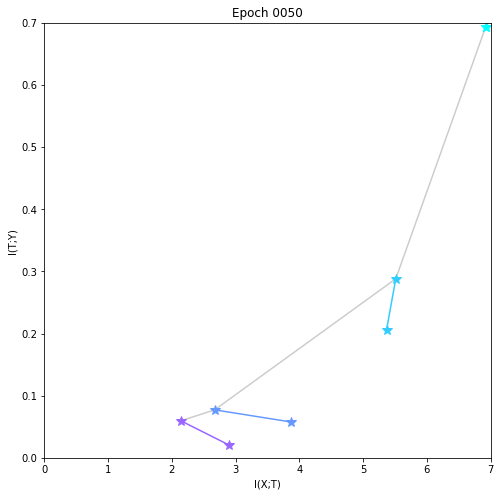

In [20]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim((0,7))
ax.set_ylim((0.,0.7))
ax.set_xlabel('I(X;T)')
ax.set_ylabel('I(T;Y)')
title = ax.set_title('')
animate(1)